In [1]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from ipywidgets import Image
from IPython import display
import numpy as np
from scipy.spatial import Delaunay
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
%matplotlib widget

In [2]:
w1data = pd.read_csv("nfl-big-data-bowl-2023/week1.csv")
w2data = pd.read_csv("nfl-big-data-bowl-2023/week2.csv")
w3data = pd.read_csv("nfl-big-data-bowl-2023/week3.csv")
w4data = pd.read_csv("nfl-big-data-bowl-2023/week4.csv")
w5data = pd.read_csv("nfl-big-data-bowl-2023/week5.csv")
w6data = pd.read_csv("nfl-big-data-bowl-2023/week6.csv")
w7data = pd.read_csv("nfl-big-data-bowl-2023/week7.csv")
w8data = pd.read_csv("nfl-big-data-bowl-2023/week8.csv")
players_background = pd.read_csv("BigDataBowl2023/data2023/players.csv", index_col='nflId')
madden_df = pd.read_csv("BigDataBowl2023/merged_df.csv")
median_df = pd.read_csv("BigDataBowl2023/all_pos_df.csv", index_col=0)

In [3]:
print(len(w1data['playId'].unique()))

1021


In [4]:
def collect_game_info(weekdf, playId, saved=False):
    
    #slice df to single play
    playdf = weekdf.loc[weekdf["playId"] == playId]
    #reorder playdf so that they are in the right frame order
    playdf = playdf.sort_values(by = "frameId")
    if saved:
        playdf.to_csv(f'Play{playId}Frames.csv')
    return playdf

In [5]:
def gaussian(x):
    return np.exp(-(((x**2)-(2*x)+1)/(0.4*x)))

In [6]:
def val_check(x,range):
    if x < range[0]:
        return 0
    elif x > range[1]:
        return 0
    else:
        return 1

In [7]:
print(gaussian(1))

1.0


In [8]:
def find_best_player(weekdf,playId,resolution,madden_df,median_df,players_background):
    play = collect_game_info(weekdf, playId)
    
    madden_df.loc[:, 'nflId'] = madden_df['nflId'].astype('int64')
    madden_df = madden_df.set_index('nflId')
    play_df = play.dropna()
    ball_df = play[play['team'] == 'football']
    play_df.loc[:, 'frameId'] = play_df['frameId'].astype('int')
    play_df.loc[:, 'nflId'] = play_df['nflId'].astype('int64')
    player_df = play_df.set_index(['nflId', 'frameId'])
    ball_df = ball_df.set_index(['frameId'])

        # Stuff for plotting
    num_frames = len(play_df['frameId'].unique())
        #self.num_players = len(self.play_df['jerseyNumber'].unique())
    teams = player_df['team'].unique()
    #xrange = (player_df['x'].min()-10, player_df['x'].max()+10)
    #yrange = (player_df['y'].min()-10, player_df['y'].max()+10)
    player_best_scores = {}
    player_speeds = {}
    player_catchs = {}
    
    ##megauhohthis is so bad
    #getting attacker and defener names
    idx = pd.IndexSlice
    player_frame_df = player_df.loc[idx[:, 1+1], :].droplevel(-1)
    for nflId, player in player_frame_df.iterrows():
            pos = players_background.loc[nflId]['officialPosition']
            if pos =='QB':
                qb_Id = nflId
                qb_team = player['team']
                qbx, qby = player[['x', 'y']]
                direction = player['playDirection']
    xrange = (player_df['x'].min()-10, player_df['x'].max()+10)
    yrange = (player_df['y'].min()-10, player_df['y'].max()+10)
    attackers = player_frame_df[player_frame_df['team']==qb_team]
    defenders = player_frame_df[player_frame_df['team']!=qb_team]
    for nflId, player in attackers.iterrows():#collecting speed scores + generating dicts of info
                player_best_scores[nflId] = 0
                player_position = players_background.loc[nflId]['officialPosition']
                if nflId in madden_df.index:
                                player_stats = madden_df.loc[nflId]
                else:
                                player_stats = median_df.loc[player_position]
                player_speeds[nflId] = player_stats['Speed'] + player_stats['Acceleration'] + player_stats['Agility']/3
                player_catchs[nflId] = player_stats['Catching']
    for nflId, player in defenders.iterrows():
                player_position = players_background.loc[nflId]['officialPosition']
                if nflId in madden_df.index:
                                player_stats = madden_df.loc[nflId]
                else:
                                player_stats = median_df.loc[player_position]
                player_speeds[nflId] = player_stats['Speed'] + player_stats['Acceleration'] + player_stats['Agility']/3
        # Determine if the QB has the ball still                
    def if_last_frame(qbx, qby, ballx, bally):
        x_dis = qbx - ballx
        y_dis = qby - bally
        
        if ((x_dis)**2 + (y_dis)**2) < 0.5:
            is_final_frame = True
        else:
            is_final_frame = False
            
        return is_final_frame 
        
    is_final_frame = False
    final_frame = num_frames + 1
    
    # Loop from final frame to find the frame QB throws
    while is_final_frame == False:
        final_frame -= 1
        i = final_frame
        idx = pd.IndexSlice
        player_frame_df = player_df.loc[idx[:, i], :].droplevel(-1)
        for nflId, player in player_frame_df.iterrows():
            pos = players_background.loc[nflId]['officialPosition']
            if pos =='QB':
                qb_Id = nflId
                qb_team = player['team']
                qbx, qby = player[['x', 'y']]
                # print(qbx, qby)
                
        ball_frame_df = ball_df.loc[i]
        ballx, bally = ball_frame_df[['x', 'y']]
        # print(ballx, bally)
        # print('Distance ball moved = '+ str(ball_frame_df['dis']))
        
        is_final_frame = if_last_frame(qbx, qby, ballx, bally)
        # print(final_frame, is_final_frame)
        
    final_frame_list = range(final_frame-1,final_frame+1)

    for frame in [final_frame]:
        i = frame
        idx = pd.IndexSlice
        player_frame_df = player_df.loc[idx[:, i+1], :].droplevel(-1)
        #ball_frame_df = ball_df.loc[i+1]
        #ball_frame_df = ball_df.loc[i+1].to_frame().transpose() # the hatred towards pandas I have in this instant is unquantifiable with words
        #ball_frame_df['nflId'] = 'football'
        #ball_frame_df.set_index('nflId', inplace=True)

        # Find the nflId of the QB (theres probably a better way to do this but idk it)
        for nflId, player in player_frame_df.iterrows():
            pos = players_background.loc[nflId]['officialPosition']
            if pos =='QB':
                qb_Id = nflId
                qb_team = player['team']
                qbx, qby = player[['x', 'y']]


        # Sort the players into attackers and defenders
        attackers = player_frame_df[player_frame_df['team']==qb_team]
        defenders = player_frame_df[player_frame_df['team']!=qb_team]

        receiver_ratings = {'nflId':[], 'receiver rating':[]}

        qb_stats = madden_df.loc[qb_Id]

        throw_score = qb_stats['Throw On The Run'] + qb_stats['Throw Under Pressure'] + qb_stats['Throw Power'] # !!!wowowowow

        for x in np.arange(xrange[0],xrange[1]+resolution,resolution):#loop over xcoords
                for y in np.arange(yrange[0],yrange[1]+resolution,resolution):#loop over ycoords
                    min_dist = 1000000 # big
                    score = 0 # how good the space is too pass to
                    for nflId, player in defenders.iterrows():
                        dist_2_point = np.sqrt((x-player['x'])**2+ (y-player['y'])**2) / player_speeds[nflId] # weighted distance using speeds
                        if dist_2_point < min_dist:
                            min_dist = dist_2_point#results in smallest dist from defending player
                    nearest_def_dist = min_dist
                    for nflId, player in attackers.iterrows():
                        #wr,te,fb,rb,
                        player_position = players_background.loc[nflId]['officialPosition']
                        if player_position in ["WR", "TE", "FB", "RB"]:
                            
                            
                            # player['x'] and player['y'] then compre with all defenders and find min
                            
                            dist_2_point = np.sqrt((x-player['x'])**2+ (y-player['y'])**2)/ player_speeds[nflId]
                            #print(defender_to_attacker)
                            if dist_2_point < min_dist: #only if attacking player is closer to point than defending player
                                #if nflId == 42347:
                                #   print(dist_2_point,min_dist)
                                min_dist = dist_2_point
                                throw_dist = np.sqrt((x-qbx)**2 + (y-qby)**2)
                                
                                defender_to_attacker = np.inf
                                for nflId2, player2 in defenders.iterrows():
                                    trial_defender_to_attacker = np.sqrt((player['x']-player2['x'])**2+(player['y']-player2['y'])**2)
                                    if trial_defender_to_attacker < defender_to_attacker:
                                        defender_to_attacker = trial_defender_to_attacker
                                
                                if throw_dist >= 20:
                                    throw_score += qb_stats['Throw Acc Deep']
                                elif throw_dist >=10:
                                    throw_score += qb_stats['Throw Acc Mid']
                                else:
                                    throw_score += qb_stats['Throw Acc Short']
                                # Average the throw score over the 4 metrics used
                                throw_score /= 4 # !!!
                                #score defined as: yard gain * 'chance of catching' (losely defined as throwscore X catchscore) * tanh(time ball takes to reach point/ time player takes to reach points)
                                #tanh thing a metric of will the player reach the catching zone before the ball if both going at max speed
                                if direction == "left":
                                    yard = qbx-x
                                elif direction == "right":
                                    yard = x-qbx 
                                score =(yard)*np.tanh(0.25*defender_to_attacker) *np.tanh(throw_score*player_catchs[nflId]/10000)*sigma((throw_dist/(3*qb_stats['Throw Power']))/(min_dist/player_speeds[nflId]))#throw speed : player speed = roughly 3:1
                                
                                if score > player_best_scores[nflId]:
                                    
                                    player_best_scores[nflId] = score
            #for Id in player_best_scores:
           #     receiver_ratings['nflId'].append(Id)
           #     receiver_ratings['receiver rating'].append(player_best_scores[Id])
    top5Players = []
    topscores = []
    sorted_dict = dict(sorted(player_best_scores.items(), key=lambda item: item[1], reverse=True))
    for key in list(sorted_dict.keys()):
           top5Players.append(key)

           #topscores.append(sorted_dict[key])
    return top5Players, topscores
        

find_best_player(w1data,137,1,madden_df,median_df,players_background)

    

([42347, 46206, 43293, 45532, 52425, 52554, 47873, 43424, 37082, 42654, 46119],
 [])

In [9]:
def run_a_week(weekdf,weeknum):
    list_of_plays = weekdf['playId'].unique()
    #list_of_plays= list_of_plays[:20]
    with open(f'wk{weeknum}bestPlayer.csv', 'w', newline='') as f:
            write = csv.writer(f)
            write.writerow(['playId','nflId','2nd','3rd','4th','5th'])
    for playId in list_of_plays:
        try:
            best_players, best_scores = find_best_player(weekdf,playId,1,madden_df,median_df,players_background)

            with open(f'wk{weeknum}bestPlayer.csv', 'a+', newline='') as f:
                        write = csv.writer(f)
                        write.writerow([playId,best_players[0], best_players[1], best_players[2], best_players[3], best_players[4]])
                        #write.writerow([playId,best_scores[0], best_scores[1], best_scores[2], best_scores[3], best_scores[4], best_scores[5],best_scores[6], best_scores[7], best_scores[8],best_scores[9], best_scores[10]])
        
        except: 
            print(f'mega died for playId {playId}')
            with open(f'wk{weeknum}bestPlayer.csv', 'a+', newline='') as f:
                        write = csv.writer(f)
                        write.writerow([playId,'Error','Error','Error','Error','Error'])

In [10]:
run_a_week(w1data,1)

mega died for playId 282
mega died for playId 410
mega died for playId 559
mega died for playId 583
mega died for playId 764
mega died for playId 788
mega died for playId 1368
mega died for playId 1776
mega died for playId 2008
mega died for playId 2279
mega died for playId 2298
mega died for playId 2330
mega died for playId 2419
mega died for playId 2554
mega died for playId 2735
mega died for playId 2893
mega died for playId 3110
mega died for playId 3261
mega died for playId 3364
mega died for playId 3655
mega died for playId 4094
mega died for playId 4141
mega died for playId 4393
mega died for playId 56
mega died for playId 843
mega died for playId 1085
mega died for playId 1494
mega died for playId 1630
mega died for playId 1991
mega died for playId 2063
mega died for playId 2145
mega died for playId 2214
mega died for playId 2631
mega died for playId 3045
mega died for playId 3383
mega died for playId 3728
mega died for playId 3776
mega died for playId 3820
mega died for playId 

In [11]:
run_a_week(w2data,2)

mega died for playId 65
mega died for playId 111
mega died for playId 235
mega died for playId 261
mega died for playId 498
mega died for playId 543
mega died for playId 727
mega died for playId 794
mega died for playId 839
mega died for playId 884
mega died for playId 992
mega died for playId 1037
mega died for playId 1061
mega died for playId 1160
mega died for playId 1233
mega died for playId 1255
mega died for playId 1277
mega died for playId 1426
mega died for playId 1682
mega died for playId 1706
mega died for playId 1759
mega died for playId 1885
mega died for playId 1909
mega died for playId 1950
mega died for playId 1991
mega died for playId 2298
mega died for playId 2493
mega died for playId 2517
mega died for playId 2558
mega died for playId 2678
mega died for playId 2706
mega died for playId 2834
mega died for playId 2873
mega died for playId 2923
mega died for playId 2966
mega died for playId 3001
mega died for playId 3142
mega died for playId 3316
mega died for playId 339

In [12]:
run_a_week(w3data,3)

mega died for playId 54
mega died for playId 100
mega died for playId 319
mega died for playId 415
mega died for playId 620
mega died for playId 1511
mega died for playId 2084
mega died for playId 2108
mega died for playId 2266
mega died for playId 2422
mega died for playId 2476
mega died for playId 2643
mega died for playId 2713
mega died for playId 2952
mega died for playId 3119
mega died for playId 3189
mega died for playId 149
mega died for playId 223
mega died for playId 346
mega died for playId 370
mega died for playId 729
mega died for playId 772
mega died for playId 854
mega died for playId 1017
mega died for playId 1077
mega died for playId 1127
mega died for playId 1174
mega died for playId 1394
mega died for playId 1418
mega died for playId 1440
mega died for playId 1636
mega died for playId 1683
mega died for playId 2022
mega died for playId 2130
mega died for playId 2202
mega died for playId 2369
mega died for playId 2441
mega died for playId 2507
mega died for playId 2690

In [13]:
run_a_week(w4data,4)

mega died for playId 169
mega died for playId 621
mega died for playId 957
mega died for playId 981
mega died for playId 1151
mega died for playId 1262
mega died for playId 1791
mega died for playId 2023
mega died for playId 2483
mega died for playId 2505
mega died for playId 2651
mega died for playId 3163
mega died for playId 3206
mega died for playId 3331
mega died for playId 3384
mega died for playId 3504
mega died for playId 76
mega died for playId 142
mega died for playId 208
mega died for playId 293
mega died for playId 473
mega died for playId 495
mega died for playId 566
mega died for playId 667
mega died for playId 864
mega died for playId 913
mega died for playId 1158
mega died for playId 1187
mega died for playId 1246
mega died for playId 1293
mega died for playId 1315
mega died for playId 1424
mega died for playId 1446
mega died for playId 1470
mega died for playId 1514
mega died for playId 1632
mega died for playId 1661
mega died for playId 2562
mega died for playId 2610
m

In [14]:
run_a_week(w5data,5)

mega died for playId 780
mega died for playId 1381
mega died for playId 1492
mega died for playId 1775
mega died for playId 2229
mega died for playId 2540
mega died for playId 2641
mega died for playId 2906
mega died for playId 2939
mega died for playId 2963
mega died for playId 3008
mega died for playId 3095
mega died for playId 3119
mega died for playId 3373
mega died for playId 3425
mega died for playId 3447
mega died for playId 3471
mega died for playId 3495
mega died for playId 3562
mega died for playId 3584
mega died for playId 3606
mega died for playId 3800
mega died for playId 3841
mega died for playId 4003
mega died for playId 4048
mega died for playId 4074
mega died for playId 465
mega died for playId 715
mega died for playId 739
mega died for playId 828
mega died for playId 1051
mega died for playId 1112
mega died for playId 1268
mega died for playId 1396
mega died for playId 1676
mega died for playId 2340
mega died for playId 2452
mega died for playId 2474
mega died for pla

In [15]:
run_a_week(w6data,6)

mega died for playId 379
mega died for playId 500
mega died for playId 627
mega died for playId 938
mega died for playId 1054
mega died for playId 1143
mega died for playId 1752
mega died for playId 1778
mega died for playId 2016
mega died for playId 2170
mega died for playId 2241
mega died for playId 2744
mega died for playId 3090
mega died for playId 3669
mega died for playId 3761
mega died for playId 213
mega died for playId 386
mega died for playId 768
mega died for playId 802
mega died for playId 1438
mega died for playId 1693
mega died for playId 1765
mega died for playId 1853
mega died for playId 2810
mega died for playId 2831
mega died for playId 2904
mega died for playId 3080
mega died for playId 3609
mega died for playId 3631
mega died for playId 3815
mega died for playId 4047
mega died for playId 206
mega died for playId 888
mega died for playId 1126
mega died for playId 1208
mega died for playId 1230
mega died for playId 1298
mega died for playId 1326
mega died for playId 1

In [16]:
run_a_week(w7data,7)

mega died for playId 535
mega died for playId 1439
mega died for playId 1514
mega died for playId 1673
mega died for playId 2035
mega died for playId 2357
mega died for playId 2733
mega died for playId 2798
mega died for playId 3125
mega died for playId 3370
mega died for playId 3561
mega died for playId 321
mega died for playId 385
mega died for playId 641
mega died for playId 1167
mega died for playId 1191
mega died for playId 1213
mega died for playId 1267
mega died for playId 1442
mega died for playId 1463
mega died for playId 2422
mega died for playId 2621
mega died for playId 2901
mega died for playId 3028
mega died for playId 3115
mega died for playId 3152
mega died for playId 3368
mega died for playId 3442
mega died for playId 3649
mega died for playId 3683
mega died for playId 3705
mega died for playId 3843
mega died for playId 3873
mega died for playId 3897
mega died for playId 3925
mega died for playId 3949
mega died for playId 3971
mega died for playId 3993
mega died for pl

In [17]:
run_a_week(w8data,8)

mega died for playId 189
mega died for playId 917
mega died for playId 1155
mega died for playId 1261
mega died for playId 1595
mega died for playId 2367
mega died for playId 2755
mega died for playId 2953
mega died for playId 3279
mega died for playId 3670
mega died for playId 3708
mega died for playId 3751
mega died for playId 113
mega died for playId 587
mega died for playId 843
mega died for playId 1032
mega died for playId 1252
mega died for playId 1381
mega died for playId 1456
mega died for playId 1480
mega died for playId 1550
mega died for playId 1602
mega died for playId 1624
mega died for playId 1805
mega died for playId 1908
mega died for playId 2096
mega died for playId 2120
mega died for playId 2242
mega died for playId 2374
mega died for playId 3043
mega died for playId 3120
mega died for playId 3261
mega died for playId 62
mega died for playId 383
mega died for playId 514
mega died for playId 737
mega died for playId 1530
mega died for playId 1695
mega died for playId 1

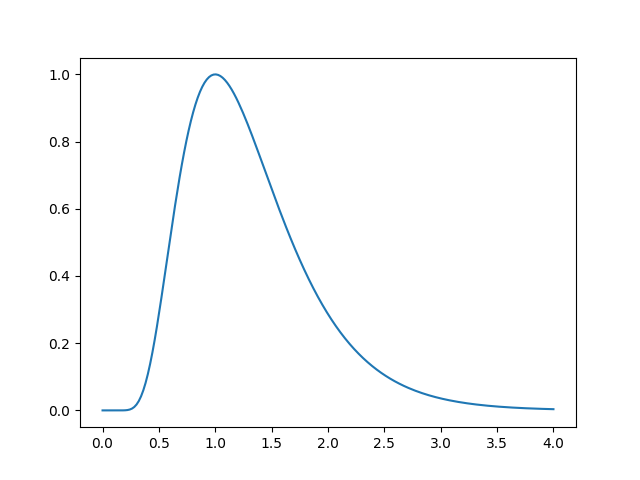

<function matplotlib.pyplot.clf()>

In [18]:
#make gaussian plot
x = np.linspace(0,4,200)
y = gaussian(x)
plt.plot(x,y)
plt.show()
plt.clf